# prep the run and load files

In [37]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

import warnings
warnings.filterwarnings("ignore")


# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh
from plotting_helpers import *           # truncate_colormap

In [38]:
%run /home/mmurakami/crios_backups/ASTE_270/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [39]:
path = "/home/mmurakami/crios_backups/ASTE_270/offline_binning/sample_images/"

In [40]:

# read one basin or whole ASTE
whole = False
if not whole:
    iB = 6    # example read from BarentsSea
    
# mymsk below defines as all Arctic down to Fram Strait and BSO but not GINs Seas
mymsk = mskBasin.copy()

# Create a boolean mask for elements that are 6 or less
# mask = mymsk <7
if whole:
    mask = (mymsk < 5) | (mymsk==6) 
else:
    mask = mymsk == 6

# Set elements that are greater than 6 to np.nan
mymsk[mask] = 1
mymsk[~mask] = np.nan

test = get_aste_tracer(mymsk,nfx,nfy)[0]
test[:,:270] = np.nan
mymsk = test

mymsk = aste_tracer2compact(mymsk,nfx,nfy)[0]

# Get the number of points where mskBasin is 6 or less
npoints = np.count_nonzero(mymsk)  # Count the number of True values in the mask
print(npoints)

364500


In [41]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt = 600 # for the MODEL, not for tendency calculations
startyr = 2002
endyr = 2019

m = 0
s = 2

# all the filenames in the system
fnames = get_fnames(dt,startyr,endyr)

times = {}
# times["2014"] = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
times["2014"] = np.array([3,4,9,10])     # tend will be calculated from tsteps before and after one month

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt,startyr,1,1)

# ocean and ice
AB_gT=0
AB_gS=0
debug = False
ffac = 1

dt = np.array([])
for i in range(1,len(datetimes)):
    dt = np.append(dt,(datetimes[i]-datetimes[i-1]).total_seconds())

In [42]:
file_name = 'budg3d_snap_set2'
THETADR = read_field3d(tsstr,nz,ny,nx,file_name,np.array(["THETADR"]),mymsk,dirIn)
SALTDR = read_field3d(tsstr,nz,ny,nx,file_name,np.array(["SALTDR"]),mymsk,dirIn)

# divide first two and second two by dt
theta = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dthetadt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
salt = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dsaltdt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)

for i in range(len(tsstr)):
    theta[i,:,:,:] = THETADR[i,:,:,:]/DRF3d/mygrid['hFacC']
    salt[i,:,:,:]  = SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC']

for i in range(len(tsstr)-1):
    dthetadt[i,:,:,:] = (THETADR[i,:,:,:]/DRF3d/mygrid['hFacC'] - THETADR[i-1,:,:,:]/DRF3d/mygrid['hFacC'])/dt[i-1]
    dsaltdt[i,:,:,:] = (SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC'] - SALTDR[i-1,:,:,:]/DRF3d/mygrid['hFacC'])/dt[i-1]

In [43]:
# also calculate surface rho from theta and salt
rho = gsw.rho(salt,theta,0)
rho.shape

(4, 50, 1350, 270)

In [44]:
# for mass tendency (m^3/s) - time is not yet included in this block
file_name = 'budg2d_snap_set1'

# assuming all files are structured the same
meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0]+ ".meta")
# try to read this with rec
fldlist = np.array(meta_budg2d_snap_set1['fldList'])
varnames = np.array(['ETAN'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# set for all months
vol = np.zeros((len(tsstr),nz, ny, nx))
print("volume allocation shape",vol.shape)

for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = [int(t1)]

    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    ETAN,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])

    # choose by basin
    ETAN = np.reshape(ETAN,(ny,nx))

    # ocean
    if debug:
        print(read,its[0],its[1]) # these iteration numbers should be the same as read

    # 3D, with rStar:
    tmpvol = np.zeros((nz, ny, nx))
    if myparms['useNLFS'] < 2 or myparms['rStar'] == 0:        # not this time
        tmpvol[0,:, :] = ETAN * myparms['rhoconst'] * RAC
        if myparms['useRFWF'] == 0:
            tmpvol[0, :, :] = np.zeros((ny, nx))
    else:    # 4/22 look at this one
        if myparms['useRFWF'] != 0:                                 # we are using this  # check if tmp1 is the same as drf3d!!
            tmp1 = mk3D_mod(mygrid['DRF'],hfC) * hfC     # m
            tmp2 = tmp1/mk3D_mod(DD,tmp1)                # drf as a fraction of total depth, this allows us to distribute etan between z
        else:
            tmp2 = drf3d / mk3D_mod(DD, tmp1)

        # this is still wrong, we want to subtract the ETAN anomaly from the existing volumes
        tmpvol =  (tmp1 + tmp2*mk3D_mod(ETAN, tmp2)) * mk3D_mod(RAC, hfC) * ffac     # volume, m * m^2  = m^3

    vol[t,:,:,:] = tmpvol * np.tile(mymsk, (nz, 1, 1))

print(vol.shape)

volume allocation shape (4, 50, 1350, 270)
(4, 50, 1350, 270)


In [95]:
(datetimes[1]-datetimes[0]).total_seconds()

2678400.0

In [138]:
# do salt tendency
# Initialize the new array with the desired shape (2, z, y, x)
dSALTDRdt = np.zeros((2, SALTDR.shape[1], SALTDR.shape[2], SALTDR.shape[3]))
# Calculate the differences and assign to the new array
dSALTDRdt[0] = (SALTDR[1] - SALTDR[0]) / (datetimes[1]-datetimes[0]).total_seconds()
dSALTDRdt[1] = (SALTDR[3] - SALTDR[2])  / (datetimes[3]-datetimes[2]).total_seconds()
print(dSALTDRdt.shape)    # PSU.m  / s

# now calculate the tendency for the two months times[0], times[2]
AB_gS = 0
G_S = np.zeros((2, SALTDR.shape[1], SALTDR.shape[2], SALTDR.shape[3]))
for i in range(dSALTDRdt.shape[0]):
    G_S[i] = (dSALTDRdt[i] - AB_gS) * mk3D_mod(RAC,dSALTDRdt[i])   # PSU.m/s * m^2 = PSU.m^3/s

(2, 50, 1350, 270)


In [139]:
# do heat tendency
# Initialize the new array with the desired shape (2, z, y, x)
dTHETADRdt = np.zeros((2, THETADR.shape[1], THETADR.shape[2], THETADR.shape[3]))
# Calculate the differences and assign to the new array
dTHETADRdt[0] = (THETADR[1] - THETADR[0]) / (datetimes[1]-datetimes[0]).total_seconds()
dTHETADRdt[1] = (THETADR[3] - THETADR[2]) / (datetimes[3]-datetimes[2]).total_seconds()
print(dTHETADRdt.shape)    # degC.m / s

# now calculate the tendency for the two months times[0], times[2]
G_T = np.zeros((2, THETADR.shape[1], THETADR.shape[2], THETADR.shape[3]))
for i in range(dTHETADRdt.shape[0]):
    G_T[i] = (dTHETADRdt[i]-AB_gT)*mk3D_mod(RAC,dTHETADRdt[i])     # degC.m/s * m^2 = degC.m^3/s

(2, 50, 1350, 270)


# make the meshes based on volume, vectors based on salttend and heat tend

In [140]:
# try new T bins where different sizes
refined_section = np.linspace(-3,8,93)
coarse_section = np.linspace(8,15,21,endpoint=False)
binsTH_edges = np.concatenate((refined_section,coarse_section[1:]))
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

# do bi-sectional form for S
coarse_section = np.linspace(0, 28, 30, endpoint=False)
refined_section = np.linspace(28, 40, 83)
binsSLT_edges = np.concatenate((coarse_section, refined_section))
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)
Tbincent,Sbincent = np.meshgrid(binsTH_centers,binsSLT_centers)

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]
dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)


# create the binned values for theta and salt
# we want to bin theta and salt into the T and S bins
binned_theta = bin_array(theta,binsTH_edges)
binned_theta = binned_theta.astype(float)
binned_theta[binned_theta == nT] = np.nan     # because the binning is setting nan to last value
binned_salinity = bin_array(salt,binsSLT_edges)
binned_salinity = binned_salinity.astype(float)
binned_salinity[binned_salinity == nS] = np.nan

In [141]:
maskArc = mskBasin * mymsk

binwidthsS_tile = np.tile(binwidthS, (112, 1)).T
binwidthsT_tile = np.tile(binwidthT, (112, 1))

idxs = np.where(maskArc == iB)
npoints = len(idxs[0])
mesh = create_TS_mesh(tsstr,nS,nT,npoints,binned_salinity, binned_theta,vol,idxs,dT,dS)
print(mesh.shape)

(4, 112, 112, 10650)


In [165]:
mydata_test_m1 = np.nansum(mesh[m],axis=2)
mydata_test_m2 = np.nansum(mesh[s],axis=2)

In [166]:
# create the mesh of vectors for GS and GT
def create_TS_mesh_vectors(attr,binned_theta,binned_salinity,nT,nS,binwidthS,binwidthT):
    '''
    Creates the tendency terms for a given attribute provided the X,Y, and Z components
    
    Inputs:
        attr: the vector sum we want to bin
        nT, nS: number of cell centers
        binwidthT, binwidthS: bin widths in T-S space for comparison

    Outputs:
        an array of shape nT, nS of the tendency values for a given basin or set of basins
    '''
    # initialize the TS mesh
    distr_attr = np.full((nT,nS),0.0)

    # initialize tiles for binwidths
    binwidthsS_tile = np.tile(binwidthS, (112, 1)).T
    binwidthsT_tile = np.tile(binwidthT, (112, 1))

    # get the indices where not nan so that we don't have to loop, hopefully faster
    indices = np.where(~np.isnan(binned_theta))
    if len(indices) == 2:
        y,x = indices[0],indices[1]
    else:
        z,y,x = indices[0],indices[1],indices[2]

    # loop over the z,y,x indices, grab the values from attr, and add them to the mesh
    # 2D case (ie gate)
    if len(indices) == 2:
        for i,j in zip(y,x):
            distr_attr[int(binned_salinity[i,j]),int(binned_theta[i,j])] += attr[i,j]

    # 3D case (ie Basin)
    elif len(indices) == 3:
        for i,j,k in zip(z,y,x):
            distr_attr[int(binned_salinity[i,j,k]),int(binned_theta[i,j,k])] += attr[i,j,k]    # degC.m^3/s OR PSU.m^3/s

    # divide by binwidthsS and binwidthsT tiles
    # heat tendency becomes Sv/PSU, salt tendency becomes Sv/degC
    #distr_attr  = distr_attr/binwidthsT_tile[:,:]/binwidthsS_tile[:,:]    # m^3/s/PSU OR m^3/s/degC
    distr_attr *= 1e-6                                                    # Sv/PSU or Sv/degC
    distr_attr[distr_attr == 0 ] = np.nan

    return distr_attr

In [167]:
m = 0
s = 2

In [168]:
G_S_vec_m1 = create_TS_mesh_vectors(G_S[m],binned_theta[m],binned_salinity[m],nT,nS,binwidthS,binwidthT)/binwidthsS_tile    # Sv
G_T_vec_m1 = create_TS_mesh_vectors(G_T[m],binned_theta[m],binned_salinity[m],nT,nS,binwidthS,binwidthT)/binwidthsT_tile    # Sv

G_S_vec_m2 = create_TS_mesh_vectors(G_S[1],binned_theta[s],binned_salinity[s],nT,nS,binwidthS,binwidthT)/binwidthsS_tile    # Sv
G_T_vec_m2 = create_TS_mesh_vectors(G_T[1],binned_theta[s],binned_salinity[s],nT,nS,binwidthS,binwidthT)/binwidthsT_tile    # Sv

# try to plot the G_S and G_T vectors

In [169]:
cmap = plt.get_cmap('RdBu_r',31).copy()
cmap.set_under(color='white')
cmap2 = plt.get_cmap('viridis',31).copy()
cmap2.set_under(color='white')

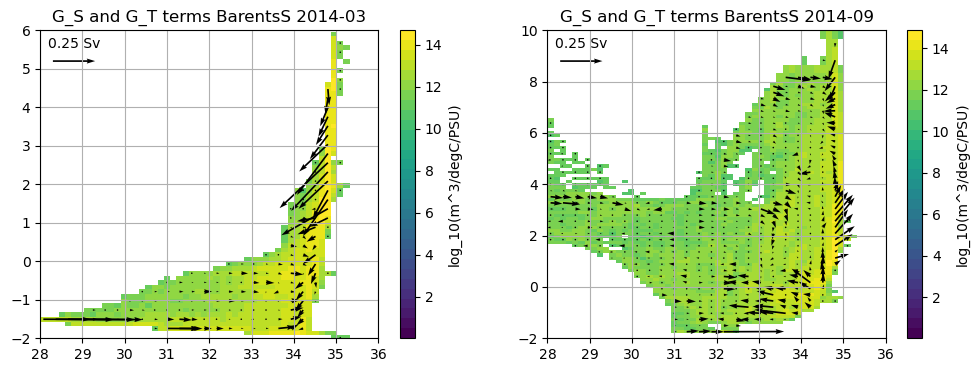

In [213]:
# try to plot GS and GT

# remake the previous figure with scaled arrows
fig = plt.figure(figsize=(12,4))

sfact = 6   # scale factor for x (PSU in denom, multiply out)
arrow_length = 0.25     # for the sverdrup arrows
step=2
t = m
U = .25

ax1 = plt.subplot(121)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(mydata_test_m1), cmap=cmap2, vmin=0.01)
# U1, V1 = scale_vectors(distr_x_iB_m1/sfact,distr_y_iB_m1)       # x units are Sv/PSU, y units are Sv/degC
U1, V1 = G_S_vec_m1,G_T_vec_m1/16
q1 = ax1.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005,scale=2e0)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("G_S and G_T terms " + strb[iB] + " " + datetimes[m].strftime("%Y-%m"))
ax1.set_xlim(28,36)
ax1.set_ylim(-2,6)
ax1.grid()
ax1.quiverkey(q1,X=0.1,Y=0.9,U = U,label=str(U) + " Sv")


ax1 = plt.subplot(122)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(mydata_test_m2), cmap=cmap2, vmin=0.01)
# U1, V1 = scale_vectors(distr_x_iB_m1/sfact,distr_y_iB_m1)       # x units are Sv/PSU, y units are Sv/degC
U1, V1 = G_S_vec_m2,G_T_vec_m2/16
q1 = ax1.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005,scale=2e0)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("G_S and G_T terms " + strb[iB] + " " + datetimes[s].strftime("%Y-%m"))
ax1.set_xlim(28,36)
ax1.set_ylim(-2,10)
ax1.grid()
ax1.quiverkey(q1,X=0.1,Y=0.9,U = U,label=str(U) + " Sv")

plt.savefig(path + "Gterms_Barents_v2.png",dpi=300)

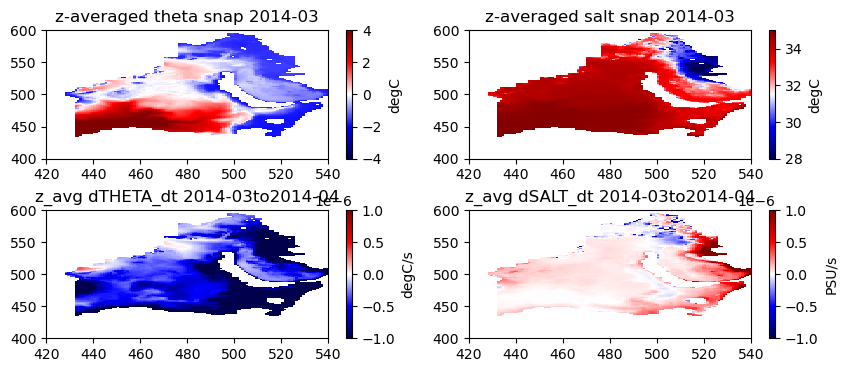

In [203]:
# do a sanity check for this with the T and S fields
fig = plt.figure()

ax = plt.subplot(221)
cb = ax.pcolormesh(np.nanmean(get_aste_tracer(theta[0],nfx,nfy),axis=0),cmap='seismic',vmin=-4,vmax=4)
ax.set_title("z-averaged theta snap " + datetimes[0].strftime("%Y-%m"))
plt.colorbar(cb,label="degC")
ax.set_xlim(420,540)
ax.set_ylim(400,600)

ax = plt.subplot(222)
cb = ax.pcolormesh(np.nanmean(get_aste_tracer(salt[0],nfx,nfy),axis=0),cmap='seismic',vmin=28,vmax=35)
ax.set_title("z-averaged salt snap " + datetimes[0].strftime("%Y-%m"))
plt.colorbar(cb,label="degC")
ax.set_xlim(420,540)
ax.set_ylim(400,600)

ax = plt.subplot(223)
cb = ax.pcolormesh(np.nanmean(get_aste_tracer(dthetadt[0],nfx,nfy),axis=0),cmap='seismic',vmin=-1e-6,vmax=1e-6)
ax.set_title("z_avg dTHETA_dt " + datetimes[0].strftime("%Y-%m") + "to" + datetimes[1].strftime("%Y-%m"))
plt.colorbar(cb,label="degC/s")
ax.set_xlim(420,540)
ax.set_ylim(400,600)

ax = plt.subplot(224)
cb = ax.pcolormesh(np.nanmean(get_aste_tracer(dsaltdt[0],nfx,nfy),axis=0),cmap='seismic',vmin=-1e-6,vmax=1e-6)
ax.set_title("z_avg dSALT_dt " + datetimes[0].strftime("%Y-%m") + "to" + datetimes[1].strftime("%Y-%m"))
plt.colorbar(cb,label="PSU/s")
ax.set_xlim(420,540)
ax.set_ylim(400,600)

plt.subplots_adjust(hspace=0.4)  # Increase hspace to increase vertical spacing

plt.savefig(path + "sanity_check_for_Gterms_Barents.png",dpi=300)

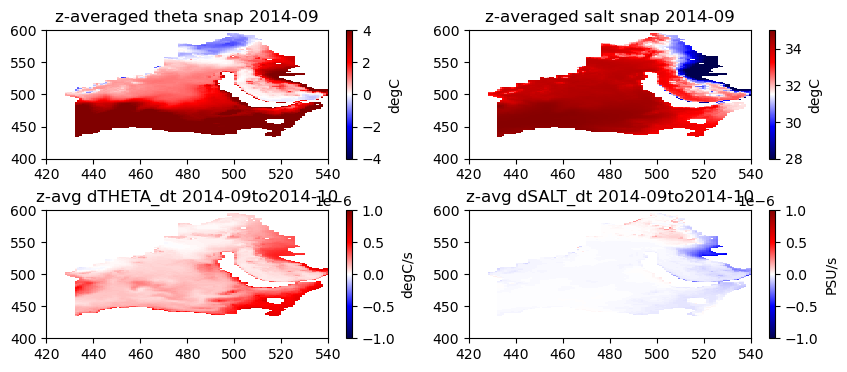

In [204]:
# do a sanity check for this with the T and S fields
fig = plt.figure()

ax = plt.subplot(221)
cb = ax.pcolormesh(np.nanmean(get_aste_tracer(theta[2],nfx,nfy),axis=0),cmap='seismic',vmin=-4,vmax=4)
ax.set_title("z-averaged theta snap " + datetimes[2].strftime("%Y-%m"))
plt.colorbar(cb,label="degC")
ax.set_xlim(420,540)
ax.set_ylim(400,600)

ax = plt.subplot(222)
cb = ax.pcolormesh(np.nanmean(get_aste_tracer(salt[2],nfx,nfy),axis=0),cmap='seismic',vmin=28,vmax=35)
ax.set_title("z-averaged salt snap " + datetimes[2].strftime("%Y-%m"))
plt.colorbar(cb,label="degC")
ax.set_xlim(420,540)
ax.set_ylim(400,600)

ax = plt.subplot(223)
cb = ax.pcolormesh(np.nanmean(get_aste_tracer(dthetadt[-1],nfx,nfy),axis=0),cmap='seismic',vmin=-1e-6,vmax=1e-6)
ax.set_title("z-avg dTHETA_dt " + datetimes[2].strftime("%Y-%m") + "to" + datetimes[3].strftime("%Y-%m"))
plt.colorbar(cb,label="degC/s")
ax.set_xlim(420,540)
ax.set_ylim(400,600)

ax = plt.subplot(224)
cb = ax.pcolormesh(np.nanmean(get_aste_tracer(dsaltdt[-1],nfx,nfy),axis=0),cmap='seismic',vmin=-1e-6,vmax=1e-6)
ax.set_title("z-avg dSALT_dt " + datetimes[2].strftime("%Y-%m") + "to" + datetimes[3].strftime("%Y-%m"))
plt.colorbar(cb,label="PSU/s")
ax.set_xlim(420,540)
ax.set_ylim(400,600)

plt.subplots_adjust(hspace=0.4)  # Increase hspace to increase vertical spacing

plt.savefig(path + "sanity_check_for_Gterms_Barents_m2.png",dpi=300)

# Try to calculate the Js and Jt terms from this

In [214]:
J_x_vec_m1 = create_TS_mesh_vectors(G_S[m],binned_theta[m],binned_salinity[m],nT,nS,binwidthS,binwidthT)/binwidthsS_tile/binwidthsT_tile    # PSU.m^3/s -> Sv/degC
J_y_vec_m1 = create_TS_mesh_vectors(G_T[m],binned_theta[m],binned_salinity[m],nT,nS,binwidthS,binwidthT)/binwidthsS_tile/binwidthsT_tile    # Sv/PSU

J_x_vec_m2 = create_TS_mesh_vectors(G_S[1],binned_theta[s],binned_salinity[s],nT,nS,binwidthS,binwidthT)/binwidthsS_tile/binwidthsT_tile    # Sv/degC
J_y_vec_m2 = create_TS_mesh_vectors(G_T[1],binned_theta[s],binned_salinity[s],nT,nS,binwidthS,binwidthT)/binwidthsS_tile/binwidthsT_tile    # Sv/PSU

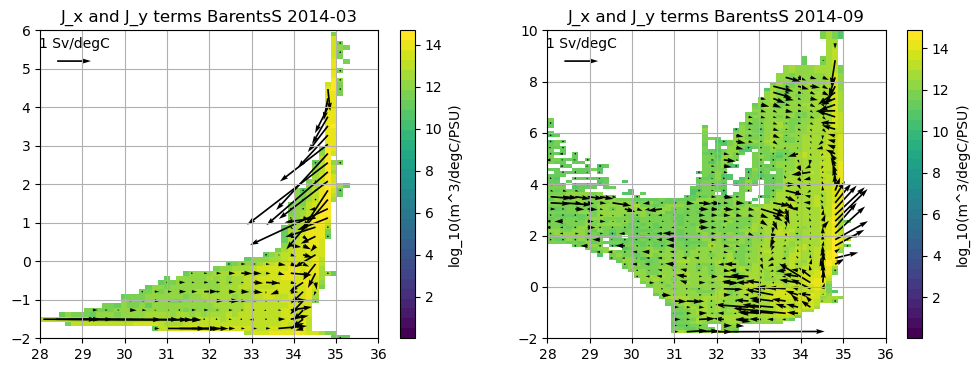

In [219]:
# try to plot GS and GT

# remake the previous figure with scaled arrows
fig = plt.figure(figsize=(12,4))

sfact = 6   # scale factor for x (PSU in denom, multiply out)
arrow_length = 0.25     # for the sverdrup arrows
step=2
t = m
U = 1
scale=1e1

ax1 = plt.subplot(121)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(mydata_test_m1), cmap=cmap2, vmin=0.01)
# U1, V1 = scale_vectors(distr_x_iB_m1/sfact,distr_y_iB_m1)       # x units are Sv/PSU, y units are Sv/degC
U1, V1 = J_x_vec_m1,J_y_vec_m1/16
q1 = ax1.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005,scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("J_x and J_y terms " + strb[iB] + " " + datetimes[m].strftime("%Y-%m"))
ax1.set_xlim(28,36)
ax1.set_ylim(-2,6)
ax1.grid()
ax1.quiverkey(q1, X=0.45, Y=0.65, U=U, label=str(U) + " Sv/degC", labelpos='E')
ax1.quiverkey(q1, X=0.11, Y=0.95, U=U, label=str(U) + " Sv/PSU", labelpos='E',angle = 90)

ax1 = plt.subplot(122)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(mydata_test_m2), cmap=cmap2, vmin=0.01)
# U1, V1 = scale_vectors(distr_x_iB_m1/sfact,distr_y_iB_m1)       # x units are Sv/PSU, y units are Sv/degC
U1, V1 = J_x_vec_m2,J_y_vec_m2/16
q1 = ax1.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005,scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("J_x and J_y terms " + strb[iB] + " " + datetimes[s].strftime("%Y-%m"))
ax1.set_xlim(28,36)
ax1.set_ylim(-2,10)
ax1.grid()
ax1.quiverkey(q1, X=0.45, Y=0.65, U=U, label=str(U) + " Sv/degC", labelpos='E')
ax1.quiverkey(q1, X=0.11, Y=0.95, U=U, label=str(U) + " Sv/PSU", labelpos='E',angle = 90)


plt.savefig(path + "Jterms_Barents.png",dpi=300)